# Genetics

---
embed-resources: true
---

## Introduction

The purpose of this report is to work towards a proof of concept that gene expression can be fed into a machine learning algorithm to detect and identify cancers. The model will classify a set of genes into one of five potential cancer types.

## Methods

In [230]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# tuning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix

### Data

In [231]:
# load data
genetics_train = pd.read_parquet(
    "https://cs307.org/lab/data/genetics-train.parquet",
)
genetics_test = pd.read_parquet(
    "https://cs307.org/lab/data/genetics-test.parquet",
)

# create X and y for train
X_train = genetics_train.drop(columns=["cancer"])
y_train = genetics_train["cancer"]

# create X and y for test
X_test = genetics_test.drop(columns=["cancer"])
y_test = genetics_test["cancer"]

Each observation contains gene expression information from a tissue sample of a patient. The data dictionary is detailed below.

### Response
**`cancer`**

- [object] the clinically determined cancer type, one of:
    - BRCA: Breast Invasive Carcinoma
    - PRAD: Prostate Adenocarcinoma
    - KIRC: Kidney Renal Clear Cell Carcinoma
    - LUAD: Lung Adenocarcinoma
    - COAD: Colon Adenocarcinoma

### Features
**`gene_####`**
- [float64] gene expression (for gene number #### in the dataset) quantification as measured by an Illumina HiSeq platform

In [232]:
# summary statistics
genetics_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
663,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
148,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
347,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
496,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
360,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
421,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
677,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
697,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


The dataset has 128 samples and 2000 features.

In [233]:
# | echo: False
pd.concat([genetics_train['cancer'].value_counts(),genetics_train['cancer'].value_counts(normalize=True)],axis=1)

,count,proportion
cancer,,
BRCA,47,0.367188
LUAD,28,0.218750
PRAD,24,0.187500
KIRC,19,0.148438
COAD,10,0.078125


Class imbalance is not too major.

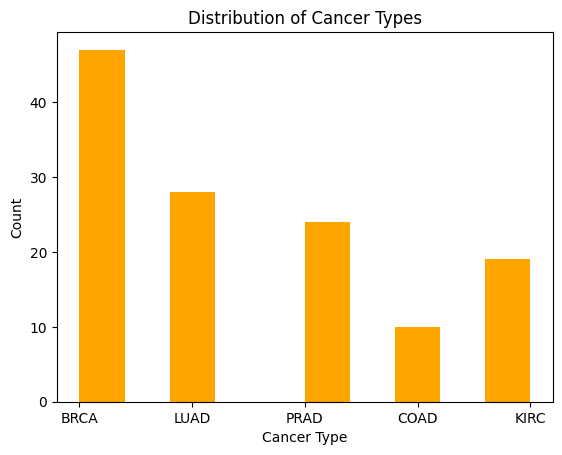

In [234]:
# | echo: False
# | lightbox: True
# exploratory visualization
plt.hist(genetics_train['cancer'], color='orange')
plt.title("Distribution of Cancer Types")
plt.ylabel('Count')
plt.xlabel("Cancer Type")
plt.show()

This histogram visualizes the distribution of cancer types in the training dataset

### Models

In [235]:
# process data for ML
target = 'cancer'
features = X_train.columns

In [236]:
# train models
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', num_pipeline, features)
    ],
    remainder='drop'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('estimator', DecisionTreeClassifier())
    ]
)

In [237]:
param_grid = [
    {
        "estimator": [DecisionTreeClassifier()],
        "estimator__max_depth": range(2, 50, 3),
    },
        {
        "estimator": [DecisionTreeClassifier()],
        "estimator__min_samples_split": range(2, 50, 3),
    },
    {
        "estimator": [KNeighborsClassifier()],
        "estimator__n_neighbors": range(1, 100, 1),
    },
]

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
_ = model.fit(X_train, y_train)

/Users/ryansponzilli/Developer/UIUC/cs307/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [238]:
model.best_params_, model.best_score_

({'estimator': KNeighborsClassifier(), 'estimator__n_neighbors': 1},
 np.float64(0.9923076923076923))

After model selection and parameter tuning with cross validation, the chosen model is a `KNNeighborsClassifier` with `n_neighbors = 1` This acheives the highest train accuracy and test accuracy.

## Results

In [243]:
# report model metrics
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 1.0


This model produces a test accuracy score of 100%.

In [245]:
# | echo: false
# | output: false
# serialize model
dump(model, 'genetics.joblib')

['genetics.joblib']

## Discussion

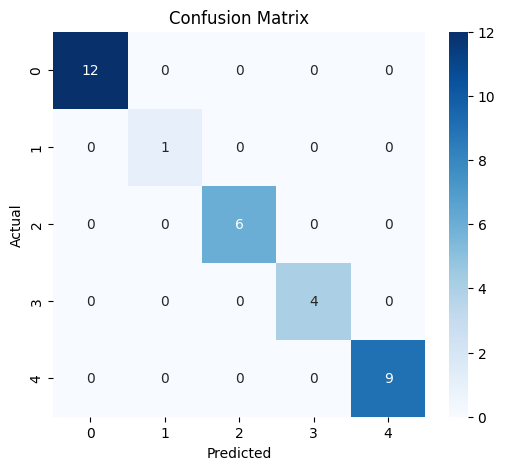

In [253]:
# | echo: False
# | lightbox: True
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

I would recommend against putting this model into practice. Even though the test accuracy is 100%, we have a relatively small sample size and `n_neighbors = 1` is likely overfitting the model. Considering the life and death nature of cancer, a model with concerns like this should never actually be used. However, as a proof of concept, I believe that this model demonstrates that with a much larger dataset and more careful model selection and parameter tuning, machine learning could be *somewhat useful* when diagnosing cancer patients.